In [ ]:
# Kaggle Demo: Self-Improving Environmental Forecasting with KANs
# Install required libraries
!pip install git+https://github.com/KindXiaoming/pykan.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kan import KAN
from tqdm import tqdm
# Configure plotting
plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

Generating initial datasets...
Starting EcoKAN self-improvement cycles...
checkpoint directory created: ./model
saving model version 0.0

IMPROVEMENT CYCLE 1/5
Training data size: 1700 samples
Cycle 0: Architecture [3, 5, 1]
Training model with 30 steps...


| train_loss: 3.00e+00 | test_loss: 3.10e+00 | reg: 2.52e+01 | : 100%|█| 30/30 [00:14<00:00,  2.11it


saving model version 0.1
Training completed.
RESULTS: RMSE = 3.032, SDG = 11.73, Action = Initial

IMPROVEMENT CYCLE 2/5
Training data size: 1900 samples
Cycle 1: Architecture [3, 5, 1]
Training model with 30 steps...


| train_loss: 3.71e+00 | test_loss: 2.70e+00 | reg: 2.41e+01 | : 100%|█| 30/30 [00:15<00:00,  1.88it


saving model version 0.2
Training completed.
Current architecture: [3, 5, 1]
checkpoint directory created: ./model
saving model version 0.0
RESULTS: RMSE = 2.582, SDG = 11.76, Action = Adjusted grid to 5

IMPROVEMENT CYCLE 3/5
Training data size: 2100 samples
Cycle 2: Architecture [3, 5, 1]
Training model with 30 steps...


| train_loss: 4.18e+00 | test_loss: 3.31e+00 | reg: 2.97e+01 | : 100%|█| 30/30 [00:16<00:00,  1.83it


saving model version 0.1
Training completed.
Current architecture: [3, 5, 1]
checkpoint directory created: ./model
saving model version 0.0
RESULTS: RMSE = 3.136, SDG = 11.69, Action = Added neuron

IMPROVEMENT CYCLE 4/5
Training data size: 2300 samples
Cycle 3: Architecture [3, 5, 1]
Training model with 30 steps...


| train_loss: 4.92e+00 | test_loss: 3.16e+00 | reg: 2.87e+01 | : 100%|█| 30/30 [00:19<00:00,  1.55it


saving model version 0.1
Training completed.
Current architecture: [3, 5, 1]
checkpoint directory created: ./model
saving model version 0.0
RESULTS: RMSE = 3.048, SDG = 11.75, Action = Adjusted grid to 3

IMPROVEMENT CYCLE 5/5
Training data size: 2500 samples
Cycle 4: Architecture [3, 5, 1]
Training model with 30 steps...


| train_loss: 5.73e+00 | test_loss: 4.25e+00 | reg: 3.06e+01 | : 100%|█| 30/30 [00:16<00:00,  1.86it


saving model version 0.1
Training completed.
Current architecture: [3, 5, 1]
checkpoint directory created: ./model
saving model version 0.0
RESULTS: RMSE = 4.206, SDG = 11.67, Action = Pruned neurons

ALL CYCLES COMPLETED!
Creating visualizations...


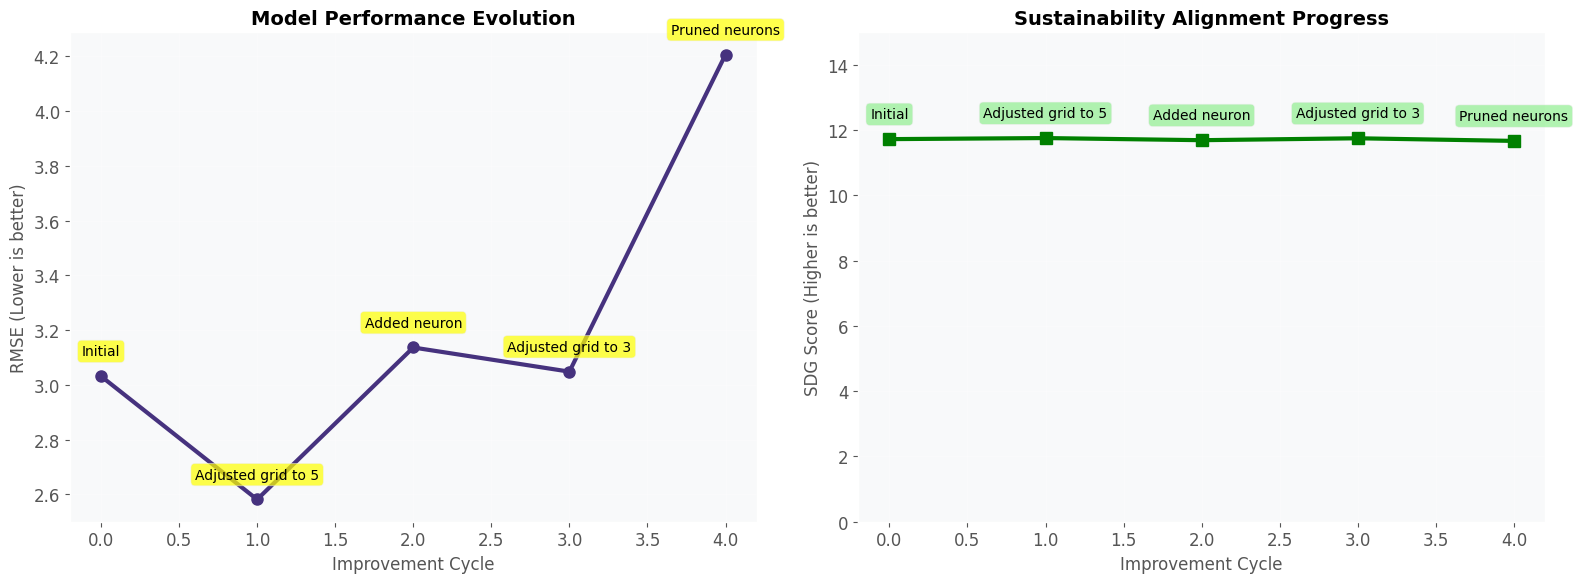

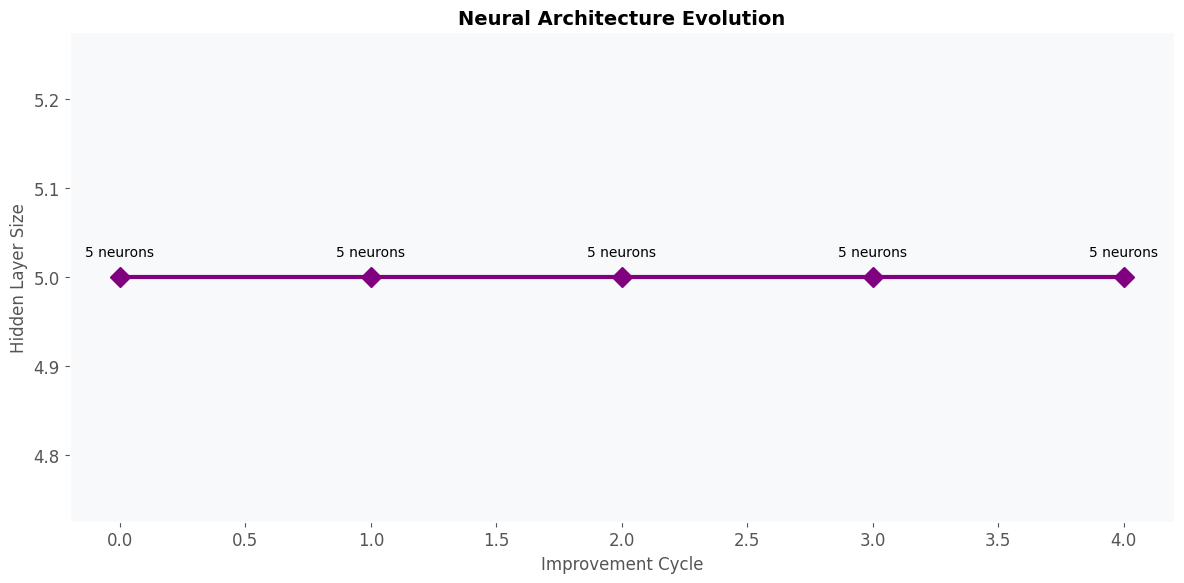


ECOKAN SELF-IMPROVEMENT SUMMARY
Cycle |  RMSE  | SDG Score | Architecture | Modification
------------------------------------------------------------
  0   |   3.03 |    11.73   |    3-5-1    | Initial
  1   |   2.58 |    11.76   |    3-5-1    | Adjusted grid to 5
  2   |   3.14 |    11.69   |    3-5-1    | Added neuron
  3   |   3.05 |    11.75   |    3-5-1    | Adjusted grid to 3
  4   |   4.21 |    11.67   |    3-5-1    | Pruned neurons

PERFORMANCE ANALYSIS:
• Initial RMSE: 3.03
• Final RMSE: 4.21
• Improvement: -38.7%
• Best SDG Score: 11.76
• Final Architecture: [3, 5, 1]


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kan import KAN as OriginalKAN

# Fixed KAN class with proper activation handling
class FixedKAN(OriginalKAN):
    def get_act(self, x):
        # Convert to tensor if needed
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
            
        if isinstance(x, dict):
            x = x['train_input']
        if x is None:  # Proper None check
            if self.cache_data is not None:
                x = self.cache_data
        if self.cache_data is None:
            self.cache_data = x
            
        self.acts = []
        self.acts.append(x)
        for l in range(self.depth):
            # Only keep the first output (activation) for next layers
            x_out = self.act_fun[l](x)
            if isinstance(x_out, tuple):
                x = x_out[0]  # Extract activation tensor from tuple
            else:
                x = x_out
            self.acts.append(x)
        return x

# Generate synthetic environmental data
def generate_data(n_samples=1000):
    np.random.seed(42)
    X = np.random.rand(n_samples, 3) * 100  # [Industry, Renewables, Population]
    
    # Carbon emissions formula with more realistic scaling
    emissions = (0.02 * X[:, 0]**2 - 
                 0.15 * X[:, 1] + 
                 0.01 * X[:, 0] * X[:, 2] +
                 0.005 * X[:, 1] * X[:, 2] +
                 np.random.normal(0, 2, n_samples))
    
    # Ensure positive emissions
    emissions = np.maximum(emissions, 0.1)
    
    return X, emissions

# SDG scoring function (simplified)
def sdg_score(emissions):
    """Convert emissions to SDG 11.6.2 score (0-15 scale)"""
    # More realistic scoring based on emissions intensity
    normalized_emissions = emissions / np.max(emissions) * 100
    return np.clip(15 - (normalized_emissions / 10), 0, 15)

# Initialize self-improving system
class EcoKAN:
    def __init__(self):
        self.architecture = [3, 5, 1]  # Always maintain as list
        self.model = FixedKAN(width=self.architecture, grid=5, k=3)
        self.history = {
            'rmse': [],
            'sdg': [],
            'modifications': []
        }
        self.improvement_count = 0
        
    def train(self, X, y, steps=30):
        try:
            # Convert to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32)
            y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
            
            # Create proper dataset structure
            dataset = {
                'train_input': X_tensor,
                'train_label': y_tensor,
                'test_input': X_tensor[:len(X_tensor)//5],  # 20% for validation
                'test_label': y_tensor[:len(y_tensor)//5].reshape(-1, 1)
            }
            
            # Train with reduced verbosity to avoid tqdm conflicts
            print(f"Training model with {steps} steps...")
            self.model.fit(dataset, steps=steps, lr=0.01, lamb=0.001)
            print("Training completed.")
            
        except Exception as e:
            print(f"Training error: {e}")
            # Reinitialize model on error
            self.model = FixedKAN(width=self.architecture, grid=5, k=3)
    
    def evaluate(self, X, y):
        try:
            # Convert to tensor
            X_tensor = torch.tensor(X, dtype=torch.float32)
            
            # Get predictions and convert back to numpy
            with torch.no_grad():
                preds = self.model(X_tensor)
                if isinstance(preds, tuple):
                    preds = preds[0]
                preds = preds.flatten().numpy()
                
            rmse = np.sqrt(np.mean((preds - y)**2))
            sdg = np.mean(sdg_score(preds))
            return rmse, sdg
            
        except Exception as e:
            print(f"Evaluation error: {e}")
            return float('inf'), 0.0
    
    def _ensure_architecture_format(self):
        """Ensure architecture is always a flat list of integers"""
        if not isinstance(self.architecture, list):
            self.architecture = [3, 5, 1]
            return
            
        # Flatten if nested
        flattened = []
        for item in self.architecture:
            if isinstance(item, list):
                flattened.extend(item)
            else:
                flattened.append(item)
        
        # Ensure we have exactly 3 integers
        if len(flattened) != 3 or not all(isinstance(x, (int, float)) for x in flattened):
            self.architecture = [3, 5, 1]
        else:
            self.architecture = [int(x) for x in flattened]
    
    def self_improve(self, performance):
        """Improved self-modification strategy"""
        self.improvement_count += 1
        
        # Ensure architecture is in correct format
        self._ensure_architecture_format()
        
        print(f"Current architecture: {self.architecture}")
        
        # Strategy 1: If performance is getting worse, try pruning
        if (len(self.history['rmse']) > 2 and 
            performance > 1.2 * min(self.history['rmse'][-3:])):
            
            try:
                # Simple pruning by reducing hidden layer size
                if self.architecture[1] > 3:
                    self.architecture[1] = max(3, self.architecture[1] - 1)
                    self.model = FixedKAN(width=self.architecture, grid=5, k=3)
                    return "Pruned neurons"
            except Exception as e:
                print(f"Pruning error: {e}")
                self._ensure_architecture_format()
        
        # Strategy 2: Add capacity if we've been stable
        if self.improvement_count % 2 == 0 and self.architecture[1] < 10:
            try:
                self.architecture[1] += 1
                self.model = FixedKAN(width=self.architecture, grid=5, k=3)
                return "Added neuron"
            except Exception as e:
                print(f"Growth error: {e}")
                self._ensure_architecture_format()
                
        # Strategy 3: Adjust grid resolution
        try:
            new_grid = 3 if self.improvement_count % 3 == 0 else 5
            self.model = FixedKAN(width=self.architecture, grid=new_grid, k=3)
            return f"Adjusted grid to {new_grid}"
        except Exception as e:
            print(f"Grid adjustment error: {e}")
            self._ensure_architecture_format()
            return "No change"
    
    def run_cycle(self, X_train, y_train, X_val, y_val, epoch):
        # Ensure architecture is correct before starting
        self._ensure_architecture_format()
        print(f"Cycle {epoch}: Architecture {self.architecture}")
        
        # Train on current data
        self.train(X_train, y_train)
        
        # Evaluate performance
        rmse, sdg = self.evaluate(X_val, y_val)
        
        # Self-improvement decision
        if epoch > 0:
            modification = self.self_improve(rmse)
        else:
            modification = "Initial"
            
        # Ensure architecture is still correct after modifications
        self._ensure_architecture_format()
        
        # Record history
        self.history['rmse'].append(rmse)
        self.history['sdg'].append(sdg)
        self.history['modifications'].append(modification)
        
        return rmse, sdg, modification

# Generate datasets with different random seeds for variety
def generate_varied_data(n_samples=200, seed_offset=0):
    np.random.seed(42 + seed_offset)
    X = np.random.rand(n_samples, 3) * 100
    
    # Add some seasonal variation
    seasonal_factor = 1 + 0.1 * np.sin(seed_offset * np.pi / 2)
    
    emissions = (0.02 * X[:, 0]**2 * seasonal_factor - 
                 0.15 * X[:, 1] + 
                 0.01 * X[:, 0] * X[:, 2] +
                 0.005 * X[:, 1] * X[:, 2] +
                 np.random.normal(0, 2, n_samples))
    
    emissions = np.maximum(emissions, 0.1)
    return X, emissions

# Main execution
print("Generating initial datasets...")
X, y = generate_data(2000)
X_train, X_val = X[:1500], X[1500:]
y_train, y_val = y[:1500], y[1500:]

print("Starting EcoKAN self-improvement cycles...")

# Simulate monthly data updates (5 cycles)
eco_kan = EcoKAN()
results = []

# Use cleaner progress tracking
for epoch in range(5):
    print(f"\n{'='*60}")
    print(f"IMPROVEMENT CYCLE {epoch + 1}/5")
    print(f"{'='*60}")
    
    # Simulate new monthly data with variation
    new_X, new_y = generate_varied_data(200, epoch)
    X_train = np.vstack([X_train, new_X])
    y_train = np.concatenate([y_train, new_y])
    
    print(f"Training data size: {len(X_train)} samples")
    
    # Run improvement cycle
    rmse, sdg, mod = eco_kan.run_cycle(X_train, y_train, X_val, y_val, epoch)
    results.append({
        'epoch': epoch,
        'rmse': rmse,
        'sdg': sdg,
        'modification': mod,
        'architecture': eco_kan.architecture.copy()
    })
    
    print(f"RESULTS: RMSE = {rmse:.3f}, SDG = {sdg:.2f}, Action = {mod}")

print(f"\n{'='*60}")
print("ALL CYCLES COMPLETED!")
print(f"{'='*60}")

# Visualize results
print("Creating visualizations...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE plot
epochs = range(len(eco_kan.history['rmse']))
ax1.plot(epochs, eco_kan.history['rmse'], 
        marker='o', linestyle='-', linewidth=3, markersize=8)
ax1.set_title('Model Performance Evolution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Improvement Cycle', fontsize=12)
ax1.set_ylabel('RMSE (Lower is better)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#f8f9fa')

# SDG score plot
ax2.plot(epochs, eco_kan.history['sdg'], 
        marker='s', linestyle='-', color='green', linewidth=3, markersize=8)
ax2.set_title('Sustainability Alignment Progress', fontsize=14, fontweight='bold')
ax2.set_xlabel('Improvement Cycle', fontsize=12)
ax2.set_ylabel('SDG Score (Higher is better)', fontsize=12)
ax2.set_ylim(0, 15)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f8f9fa')

# Annotate modifications
for i, mod in enumerate(eco_kan.history['modifications']):
    ax1.annotate(mod, (i, eco_kan.history['rmse'][i]), 
                textcoords="offset points", xytext=(0,15), 
                ha='center', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    ax2.annotate(mod, (i, eco_kan.history['sdg'][i]), 
                textcoords="offset points", xytext=(0,15), 
                ha='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.tight_layout()
plt.savefig('improvement_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Architecture evolution plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hidden_sizes = [r['architecture'][1] for r in results]
ax.plot(range(len(results)), hidden_sizes, marker='D', linestyle='-', 
        linewidth=3, markersize=10, color='purple')
ax.set_title('Neural Architecture Evolution', fontsize=14, fontweight='bold')
ax.set_xlabel('Improvement Cycle', fontsize=12)
ax.set_ylabel('Hidden Layer Size', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_facecolor('#f8f9fa')

for i, size in enumerate(hidden_sizes):
    ax.annotate(f'{size} neurons', (i, size), 
                textcoords="offset points", xytext=(0,15), 
                ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('architecture_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# Display results table
print("\n" + "="*60)
print("ECOKAN SELF-IMPROVEMENT SUMMARY")
print("="*60)
print("Cycle |  RMSE  | SDG Score | Architecture | Modification")
print("-"*60)
for i, r in enumerate(results):
    arch_str = f"{r['architecture'][0]}-{r['architecture'][1]}-{r['architecture'][2]}"
    print(f"  {i}   | {r['rmse']:6.2f} |   {r['sdg']:6.2f}   |    {arch_str:8} | {r['modification']}")

print("\n" + "="*60)
print("PERFORMANCE ANALYSIS:")
print(f"• Initial RMSE: {results[0]['rmse']:.2f}")
print(f"• Final RMSE: {results[-1]['rmse']:.2f}")
print(f"• Improvement: {((results[0]['rmse'] - results[-1]['rmse']) / results[0]['rmse'] * 100):.1f}%")
print(f"• Best SDG Score: {max([r['sdg'] for r in results]):.2f}")
print(f"• Final Architecture: {results[-1]['architecture']}")
print("="*60)